# Generate heatmaps by building block

For a specified building block, generate the heatmap spanning all other building blocks it has been tried with.

In [1]:
import sys
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath('../..'))
from src.definitions import DB_PATH, PLATES_DIR
from src.analysis.heatmapfromdb import normalize_yields, get_plot, plot_heatmap, plot_heatmap_overview
from src.util.db_utils import MyDatabaseConnection
from src.util.pandas_utils import sort_by_sparsity
from src.util.utils import get_conf
con = MyDatabaseConnection()
conf = get_conf()

In [2]:
BUILDING_BLOCK = "M34"

In [3]:
exps = con.get_experiments_with_buildingblock(BUILDING_BLOCK)

In [4]:
header = [
 'exp_nr',
 'plate_nr',
 'well',
 'lab_journal_number',
 'initiator',
 'monomer',
 'terminator',
 'product_A_lcms_ratio',
 'product_B_lcms_ratio',
 'product_C_lcms_ratio',
 'product_D_lcms_ratio',
 'product_E_lcms_ratio',
 'product_F_lcms_ratio',
 'product_G_lcms_ratio',
 'product_H_lcms_ratio',
 'vl_id',
 'valid'
]

df = pd.DataFrame(data=exps, columns=header)

In [5]:
invalid_exps = [1, 2, 3,]  # different method
invalid_exps += list(range(99000, 99010))  # test exps


invalid_exps += [28,29] # experiments not evaluated yet

In [6]:
# filter invalid stuff
df = df.loc[~df["exp_nr"].isin(invalid_exps)]
# normalize
yields = normalize_yields(df, conf["heatmap"]["normalization_constant"])

In [8]:
# get rid of duplicates (some syntheses have been done in duplicate)
yields = yields.groupby(["initiator", "monomer", "terminator"]).mean().reset_index()

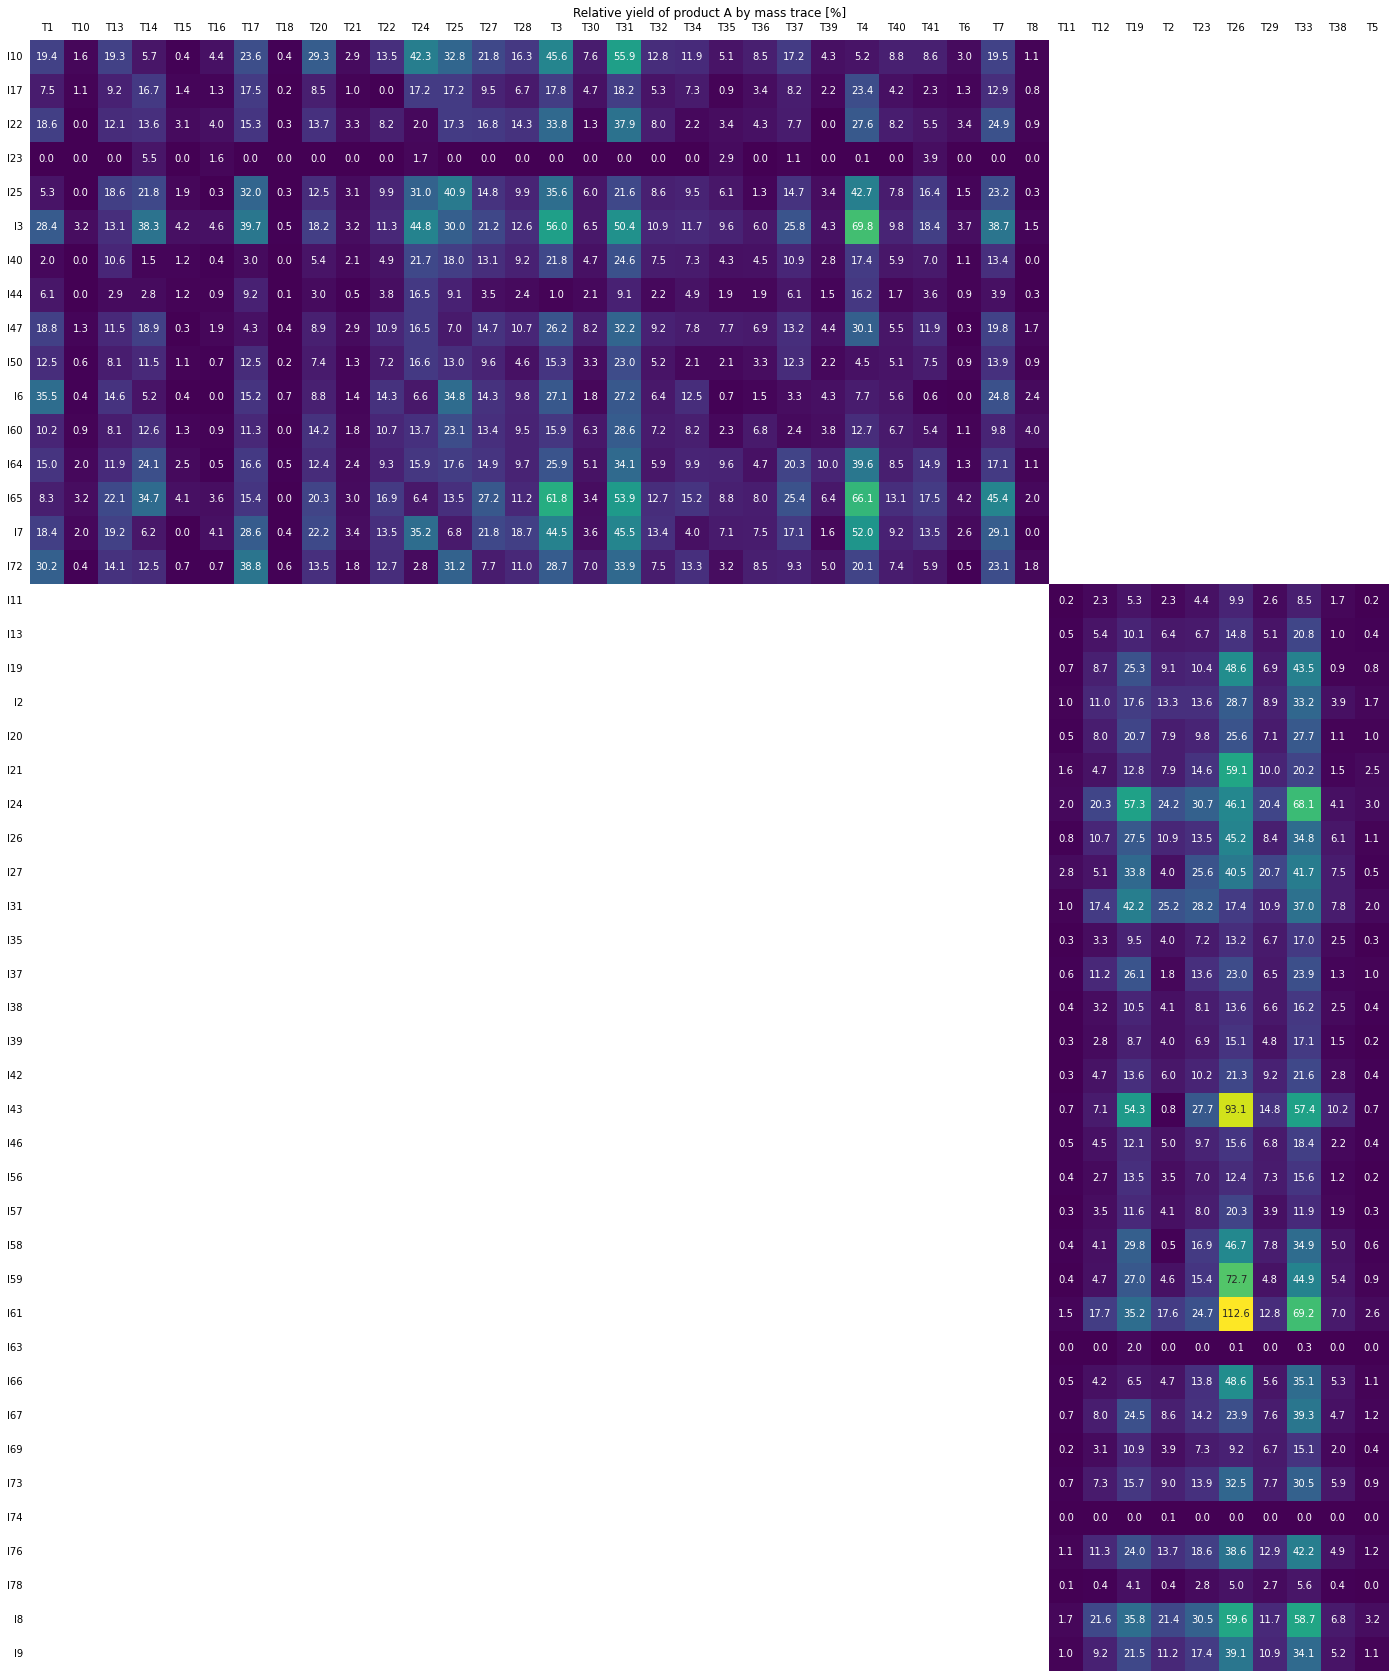

In [9]:
# set product type to plot
product_type = 'A'

# plot
plt.figure(figsize=(30,30))
if BUILDING_BLOCK.startswith("I"):
    plot_df = yields[['terminator', 'monomer', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='terminator', index='monomer', values=f'product_{product_type}_lcms_ratio')
elif BUILDING_BLOCK.startswith("M"):
    plot_df = yields[['terminator', 'initiator', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='terminator', index='initiator', values=f'product_{product_type}_lcms_ratio')
elif BUILDING_BLOCK.startswith("T"):
    plot_df = yields[['monomer', 'initiator', f'product_{product_type}_lcms_ratio']] \
        .pivot(columns='monomer', index='initiator', values=f'product_{product_type}_lcms_ratio')
plot_df = sort_by_sparsity(plot_df)
plot_df = sort_by_sparsity(plot_df, axis=1)
# plot the heatmap
get_plot(plot_df, product_type)
    
plt.show()